In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm

import corner
import copy

import multiprocessing as mp

from tqdm import tqdm

from functools import partial

# Setup

In [27]:
class HMC():
    """
    Hamiltonian Monte Carlo sampler
    https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html
    """
    
    def __init__(self, logp, dlogp, dt, L, M, n_args, prop='leapfrog'):
        """
        Arguments:
            logp: 
                Function which accepts two inputs (args, data) and returns log
                probability of the objective model
                
            dlogp:
                Function which which accepts two inputs (args, data) and returns the
                gradient of the log probability w.r.t. the parameters as a np array
                
            dt: Time step
            
            L: Number of leapfrog iterations to calculate
            
            M: covariance of momentum sampling multivariate normal
            
            n_args: number of parameters to sample
        """
        self.logp = logp
        self.dlogp = dlogp
        self.dt = dt
        self.L = L
        self.M = M
        self.n_args = n_args
        
        if prop=='leapfrog':
            self.proposal = self.prop_lf
        elif prop=='yoshida':
            self.proposal = self.prop_yo
        else:
            raise
    
    def U(self, x, data):
        return -self.logp(x,data)
    
    def dU(self, x, data):
        return self.dlogp(x,data)
    
    def K(self, v):
        return -mvnorm.logpdf(v, mean=np.zeros(self.n_args), cov=self.M)
    
    def prop_lf(self, x, v, data):
        # Leapfrog
        # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
        x, v = copy.deepcopy((x,v))

        for _ in range(self.L):
            v += (self.dt/2)*self.dU(x, data)
            x += self.dt*np.dot(np.linalg.inv(self.M), v)
            v += (self.dt/2)*self.dU(x, data)
        
        return x, v
    
    def prop_yo(self, x, v, data):
        # 4th order Yoshida integrator
        # https://en.wikiself.dlogp(x, data)pedia.org/wiki/Leapfrog_integration
        x, v = copy.deepcopy((x,v))
        
        crt2 = (2.**(1./3))
        w0 = -crt2/(2-crt2)
        w1 = 1./(2-crt2)
        c1=c4=w1/2
        c2=c3=(w0+w1)/2
        d1=d3=w1
        d2=w0
        for _ in range(self.L):
            x += c1*np.dot(np.linalg.inv(self.M), v)*self.dt
            v += d1*self.dU(x, data)*self.dt
            x += c2*np.dot(np.linalg.inv(self.M), v)*self.dt
            v += d2*self.dU(x, data)*self.dt
            x += c3*np.dot(np.linalg.inv(self.M), v)*self.dt
            v += d3*self.dU(x, data)*self.dt
            x += c4*np.dot(np.linalg.inv(self.M), v)*self.dt

        return x, v
    
    
    def sample(self, N_samp, data, init_x=None, verbose=False):
        """Samples one HMC chain for N_samp samples."""
        
        if init_x is None:
            x = 2*np.random.rand(self.n_args)-0.5
        else:
            x = init_x
            
        xs = np.zeros(shape=(N_samp, self.n_args))
        xs[0] = x
        
        i_s = range(1,N_samp)
        if verbose: # Print progress bar
            i_s = tqdm(i_s)
        
        for i in i_s:
            v = mvnorm.rvs(mean=np.zeros(self.n_args), cov=self.M)
            xnew, vnew = self.proposal(x, v, data)

            alpha = np.exp(self.U(x, data) +  self.K(v)
                           - self.U(xnew, data) - self.K(vnew))

            if np.random.rand() <= min(1, alpha):
                xs[i] = xnew
                x = xnew
            else:
                xs[i] = xs[i-1]
                
        return xs
    
    def _pool_helper(self, N_samp, data, init_x, verbose, seed):
        np.random.seed(seed)
        return self.sample(N_samp, data, init_x, verbose)
    
    def sample_pool(self, N_samp, data, N_chains, init_x=None, verbose=False):
        """Samples N_chains HMC chains in parallel, each for N_samp samples"""
        
        f = partial(self._pool_helper, N_samp, data, init_x, verbose)
        
        with mp.Pool(N_chains, initargs=(N_samp, data, init_x)) as pool:
            out = np.array(pool.map(f, 
                                    np.random.randint(0, 1e5, N_chains),
                                    ))
            
        return out

In [28]:
s = HMC(logp, dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=2, prop='leapfrog')

# syo = HMC(logp, dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=2, prop='yoshida')

x = np.array([0.01,0.5])
v = np.array([-0.68647,  0.5909])

print(s.prop_lf(x,v,data))
print(s.prop_yo(x,v,data))

(array([0.00641353, 0.57429819]), array([-0.7342918 , 26.73024194]))
(array([0.00641591, 0.57407617]), array([-0.73428627, 26.79302322]))


# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [29]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)

print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: 0.002308212726452143, sig_hat: 1.0008702689353668


In [17]:
# Define Model

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    if args[1] <= 0:
        return 0
    return np.sum(norm.logpdf(data, *args))#/len(data)

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu, sig = args
    dmu = np.sum((data - mu)/(sig**2))
    dsig = np.sum((mu**2 - sig**2 - 2*mu*data + data**2)/(sig**3))
    return np.array([dmu, dsig])#/len(data)

In [33]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=5, M=0.1*np.identity(2), n_args=2, prop='yoshida')

In [34]:
# Run sampling
xs = sampler.sample(int(1e4), data, init_x=[0.1,0.5], verbose=True)

100%|██████████| 9999/9999 [00:25<00:00, 385.28it/s]


In [35]:
# Burn
xs = xs[1000:,:]

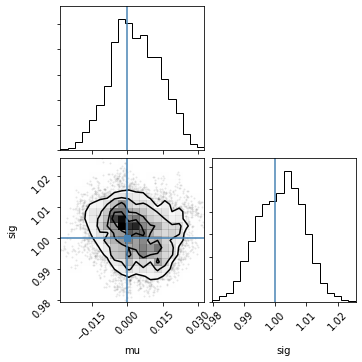

In [36]:
# Corner plot
f = corner.corner(xs.reshape(-1,2), truths=truth, labels=['mu', 'sig'])

(0, 9000)

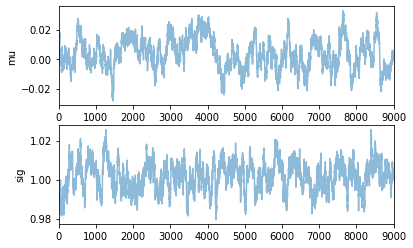

In [37]:
# Trace

f, axs = plt.subplots(2,1)

axs[0].plot(xs[:,0], label='mu', alpha=0.5)
axs[0].set_ylabel('mu')
axs[0].set_xlim(0,xs.shape[0])

axs[1].plot(xs[:,1], label='sig', alpha=0.5)
axs[1].set_ylabel('sig')
axs[1].set_xlim(0,xs.shape[0])

# Independent Multivariate Normal + LF

In [3]:
# Generate observed data
ndims = 3 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [3.89112972 4.18882387 3.25411428], sig_*: [[2.08518561 0.         0.        ]
 [0.         3.31893856 0.        ]
 [0.         0.         0.3498411 ]]
mu_hat: 3.7935510472166176, sig_hat: [[ 1.24133503  1.17209591 -1.33043799 ...  1.54745417 -0.56359104
  -0.16011633]
 [ 1.17209591  1.1304492  -1.50576567 ...  1.4912692  -0.69999469
  -0.22827491]
 [-1.33043799 -1.50576567  4.04993932 ... -1.97535009  2.368962
   0.98224407]
 ...
 [ 1.54745417  1.4912692  -1.97535009 ...  1.96731628 -0.91566972
  -0.29747709]
 [-0.56359104 -0.69999469  2.368962   ... -0.91566972  1.44297271
   0.61793266]
 [-0.16011633 -0.22827491  0.98224407 ... -0.29747709  0.61793266
   0.27108276]]


In [4]:
# Define Model
n_args = 2*ndims 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    if (sigs <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mus, np.diag(sigs)))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    dmu = np.sum((data - mus)/(sigs**2), axis=0)
    dsig = np.sum((mus**2 - sigs - 2*mus*data + data**2)/(2*sigs**2), axis=0)
    return np.concatenate([dmu, dsig])

In [5]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-3, L=5, M=0.1*np.identity(2*ndims), n_args=2*ndims)

In [6]:
# Run sampling
N_chains = 5
xs = sampler.sample_pool(int(1e4), data, N_chains, 
                         init_x = np.concatenate([mu_tru, sig_tru]) + norm.rvs(size=n_args), 
                         verbose=True)

 29%|██▊       | 2859/9999 [00:51<02:15, 52.79it/s]Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/maho/anaconda3/lib/python3.7/multiprocessing/process.py", 

KeyboardInterrupt: 

In [25]:
# Burn
xs = xs[:,1000:,:]

In [26]:
# Corner plot
f = corner.corner(xs.reshape(-1,n_args), truths=np.concatenate([mu_tru, sig_tru])
                 )#, labels=['mu', 'sig'])

ValueError: It looks like the parameter(s) in column(s) 0, 1, 2, 3, 4, 5 have no dynamic range. Please provide a `range` argument.

In [ ]:
# Trace

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,:,j], alpha=0.5)
    axs[j].set_ylabel(f'arg_{j}')
    axs[j].set_xlim(0,xs.shape[1])


# Independent Multivariate Normal + Yoshida

In [38]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [4.38061567 8.48065476 7.6199061  3.80899249 6.10432093], sig_*: [[2.63206553 0.         0.         0.         0.        ]
 [0.         0.24308677 0.         0.         0.        ]
 [0.         0.         3.28974828 0.         0.        ]
 [0.         0.         0.         0.0590193  0.        ]
 [0.         0.         0.         0.         4.19824262]]
mu_hat: 6.077795305397139, sig_hat: [[13.77647089  4.79546321 10.42750341 ... -0.27909786  5.60760056
   7.81870128]
 [ 4.79546321  4.91617801  4.64952468 ...  1.1987233   4.20345701
   2.59271787]
 [10.42750341  4.64952468  8.85463944 ... -0.46045891  5.20315128
   6.87026646]
 ...
 [-0.27909786  1.1987233  -0.46045891 ...  4.76073794  1.37020934
   0.70891011]
 [ 5.60760056  4.20345701  5.20315128 ...  1.37020934  4.14139188
   3.93913331]
 [ 7.81870128  2.59271787  6.87026646 ...  0.70891011  3.93913331
   7.02696233]]


In [39]:
# Define Model
n_args = 2*ndims 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    if (sigs <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mus, np.diag(sigs)))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mus = args[:int(n_args/2)]
    sigs = args[int(n_args/2):]
    
    dmu = np.sum((data - mus)/(sigs**2), axis=0)
    dsig = np.sum((mus**2 - sigs - 2*mus*data + data**2)/(2*sigs**2), axis=0)
    return np.concatenate([dmu, dsig])

In [40]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=1e-4, L=5, M=0.1*np.identity(2*ndims), 
              n_args=2*ndims, prop='yoshida')

In [49]:
# Run sampling
N_chains = mp.cpu_count()-1
xs = sampler.sample_pool(int(5e2), data, N_chains, 
                         init_x = np.concatenate([mu_tru, sig_tru]), verbose=True)

100%|██████████| 499/499 [00:39<00:00, 12.60it/s]


In [44]:
# Burn
xs = xs[:,1000:,:]

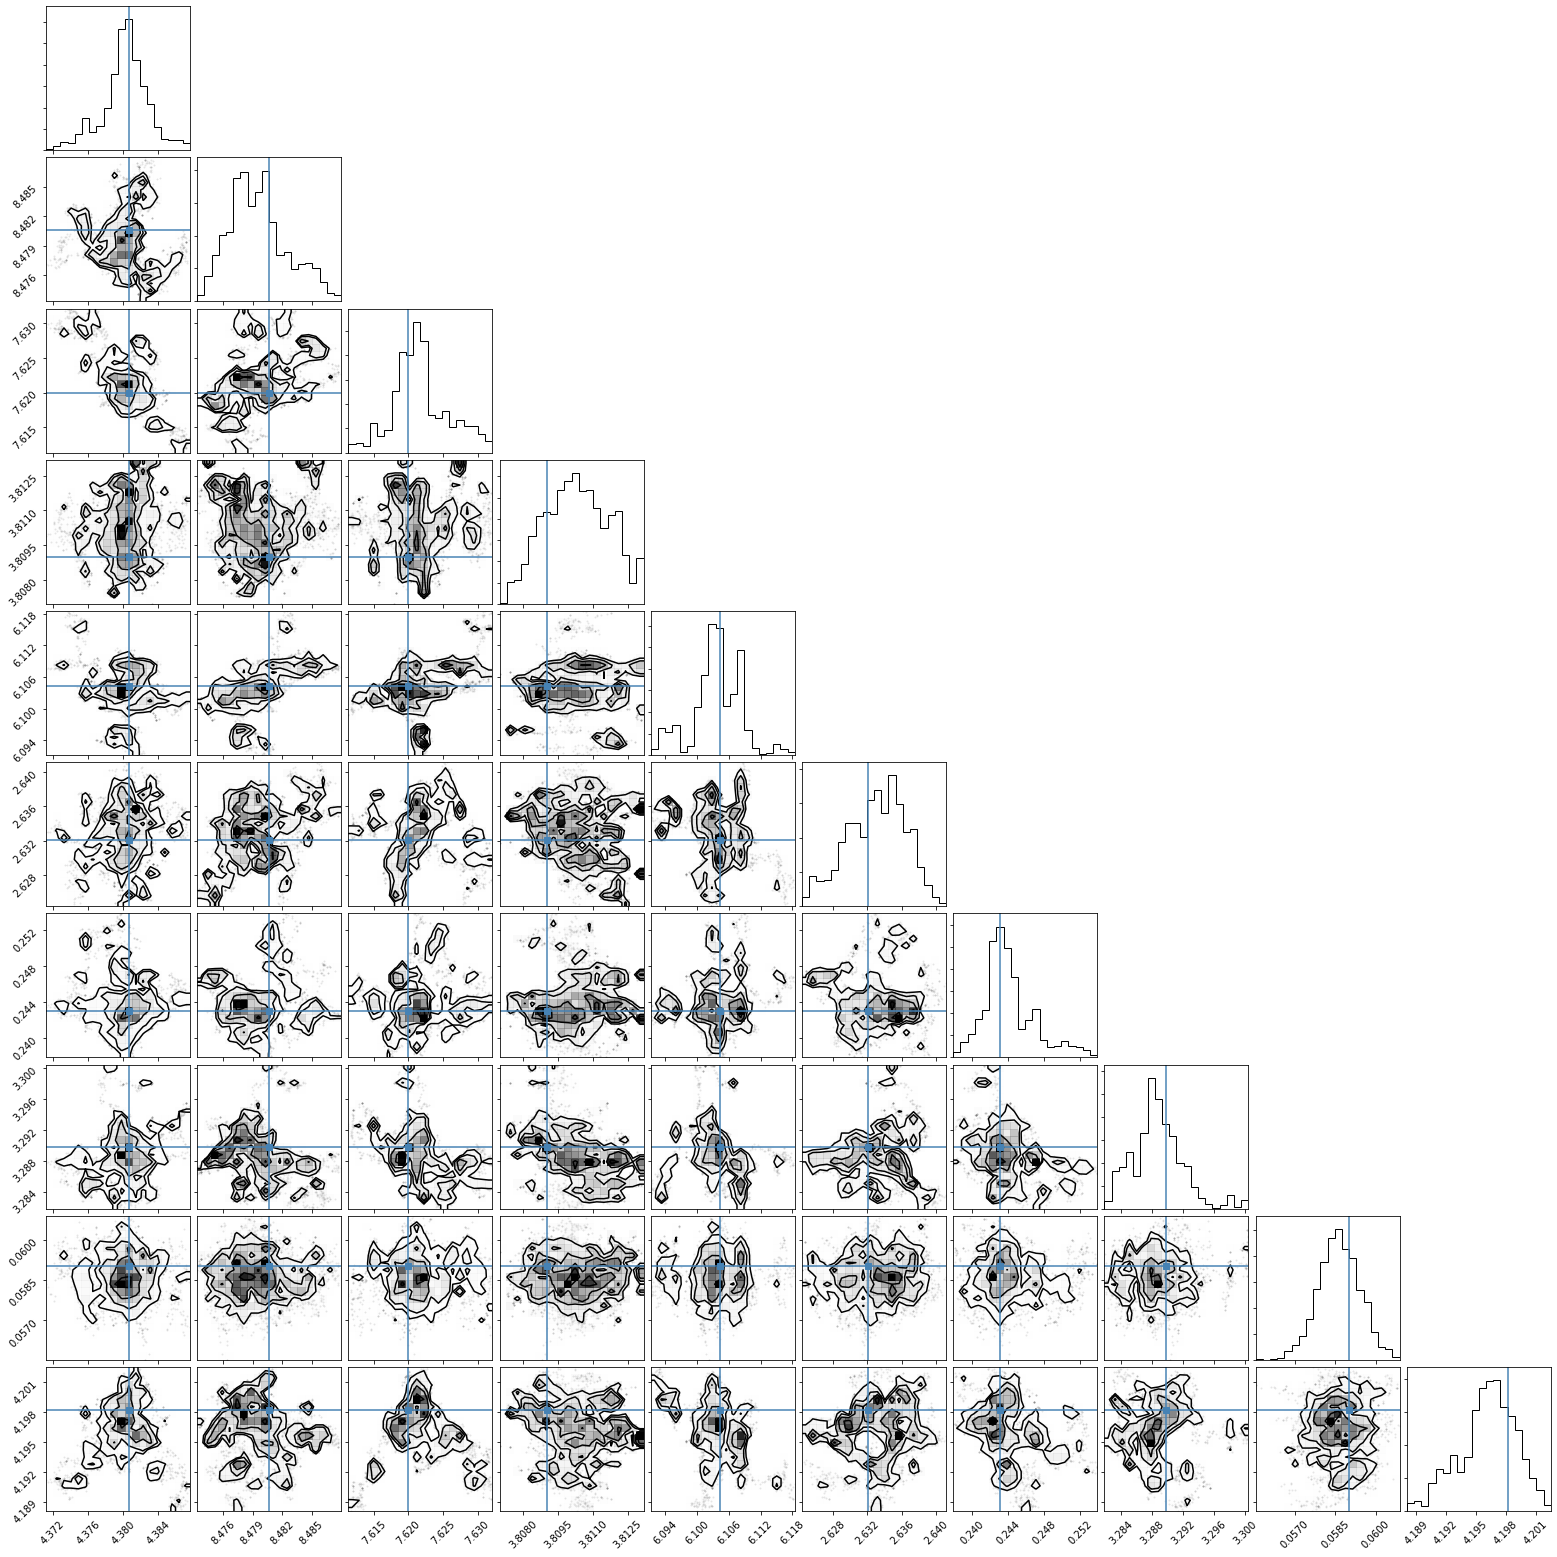

In [51]:
# Corner plot
f = corner.corner(xs.reshape(-1,n_args), truths=np.concatenate([mu_tru, sig_tru]))#, labels=['mu', 'sig'])

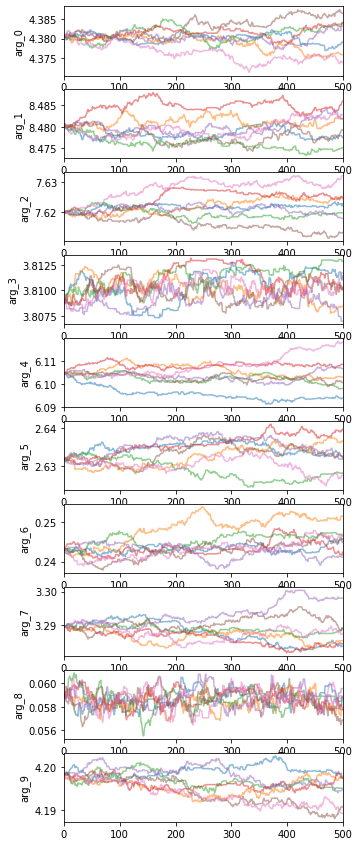

In [53]:
# Trace

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,:,j], alpha=0.5)
    axs[j].set_ylabel(f'arg_{j}')
    axs[j].set_xlim(0,xs.shape[1])


# Multivariate Normal $\mathcal{N}(0,\Sigma^{-1})$ + LF

In [3]:
def mat_to_LT(X):
    y = np.tril(Th_tru).flatten()
    return y[y!=0]

def LT_to_mat(y):
    X = np.zeros((ndims, ndims))
    X[np.tril_indices(ndims)] = y
    X+= X.T - np.diag(np.diagonal(X))
    return X

In [5]:
# Generate observed data
ndims = 3 # Number of dimensions for multivariate Gaussian
n_args = int((ndims-1)*ndims/2 + ndims)

mu_tru = np.zeros(ndims)
Th_tru = 3*np.random.rand(ndims, ndims) # Precision Matrix
Th_tru = np.dot(Th_tru, Th_tru.T)/2 # Symmetric, PSD

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.linalg.inv(Th_tru), size=N)

print(f'mu_*: {mu_tru}, Theta_*: {Th_tru}')
# print(f'mu_hat: {np.mean(data)}, sig_hat: {np.linalg.inv(np.cov(data))}')

mu_*: [0. 0. 0.], Theta_*: [[7.70748956 4.67185032 5.21873441]
 [4.67185032 4.91050239 3.87414492]
 [5.21873441 3.87414492 3.79904222]]


In [6]:
# Define Model 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu = np.zeros(ndims)
    Sig = np.linalg.inv(LT_to_mat(args))
    
    if (Sig <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mu, Sig))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu = np.zeros(ndims)
    Sig = np.linalg.inv(LT_to_mat(args))
    
    dTh_a = Sig.T# 0.5*(2*Sig - (Sig*np.identity(ndims)))
    dTh_b = 0.5*np.einsum('ij, ik->jk', data, data) #np.sum([np.outer(x,x) for x in data])
    
    return mat_to_LT(len(data)*dTh_a - dTh_b)

In [7]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=5e-3, L=5, M=0.1*np.identity(n_args), n_args=n_args,
              prop='leapfrog')

In [8]:
# Run sampling
N_chains = 5
xs = sampler.sample_pool(int(1e4), data, N_chains, 
                         init_x = mat_to_LT(Th_tru) + norm.rvs(size=(n_args)), 
                         verbose=True)

100%|██████████| 9999/9999 [00:54<00:00, 182.30it/s]


In [13]:
# Burn
xs = xs[:,1000:,:]

In [14]:
# Acceptance Rate
print(f'alpha = {len(np.unique(xs))/np.prod(xs.shape)}')

alpha = 0.6144


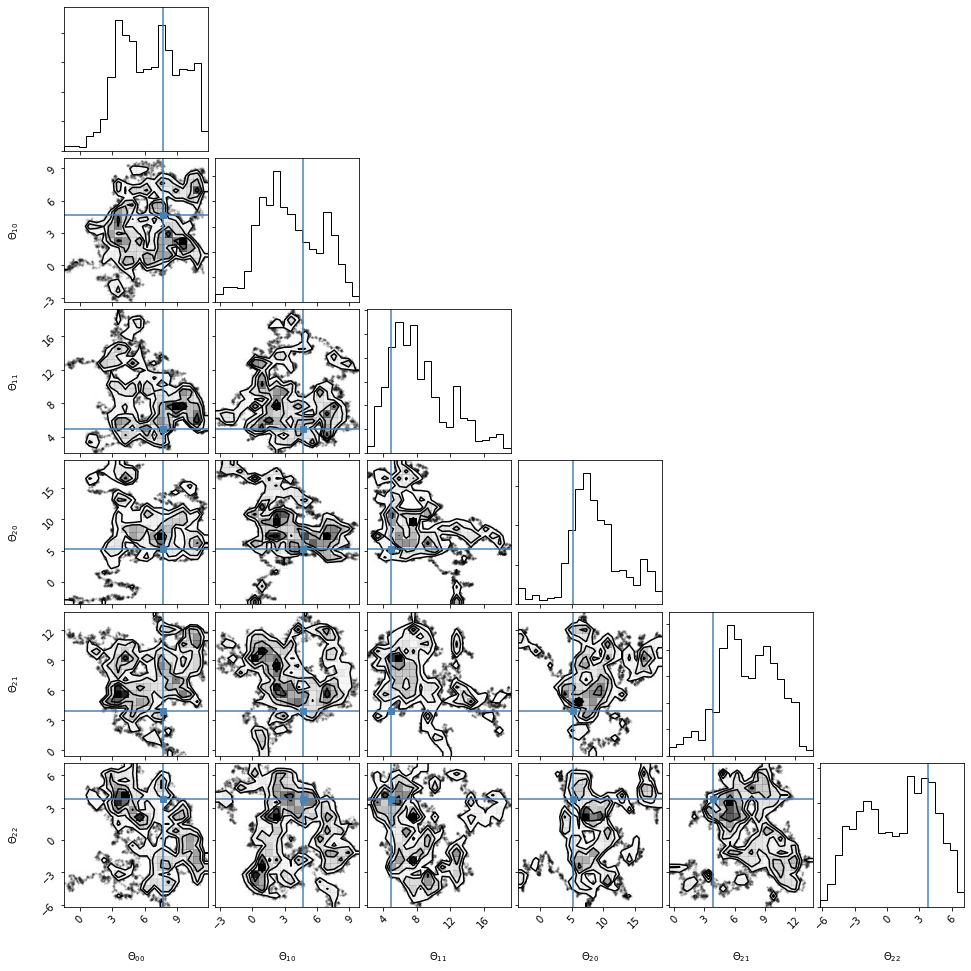

In [15]:
# Corner plot
labels = np.array([[f'$\Theta_{{{i}{j}}}$' for j in range(ndims)] for i in range(ndims)])
labels = np.tril(labels).flatten()
labels = labels[labels!='']
f = corner.corner(xs.reshape(-1,n_args), truths=mat_to_LT(Th_tru), 
                  labels=labels)

NameError: name 'labels' is not defined

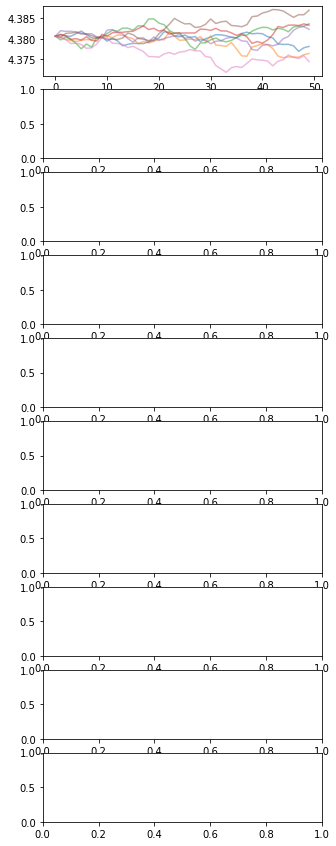

In [52]:
# Trace
r = 10

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,::r,j], alpha=0.5)
    axs[j].set_ylabel(labels[j])
    axs[j].set_xlim(0,xs.shape[1]/r)


# Multivariate Normal $\mathcal{N}(0,\Theta^{-1})$ + Yoshida

In [40]:
def mat_to_LT(X):
    y = np.tril(Th_tru).flatten()
    return y[y!=0]

def LT_to_mat(y):
    X = np.zeros((ndims, ndims))
    X[np.tril_indices(ndims)] = y
    X+= X.T - np.diag(np.diagonal(X))
    return X

In [21]:
# Generate observed data
ndims = 3 # Number of dimensions for multivariate Gaussian
n_args = int((ndims-1)*ndims/2 + ndims)

mu_tru = np.zeros(ndims)
Th_tru = 3*np.random.rand(ndims, ndims) # Precision Matrix
Th_tru = np.dot(Th_tru, Th_tru.T)/2 # Symmetric, PSD

N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.linalg.inv(Th_tru), size=N)

print(f'mu_*: {mu_tru}, Theta_*: {Th_tru}')
# print(f'mu_hat: {np.mean(data)}, sig_hat: {np.linalg.inv(np.cov(data))}')

mu_*: [0. 0. 0.], Theta_*: [[3.00334756 3.56807669 1.9415592 ]
 [3.56807669 5.36221705 2.38407423]
 [1.9415592  2.38407423 3.17394874]]


In [22]:
# Define Model 

def logp(args, data):
    """
    Calculates log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu = np.zeros(ndims)
    Sig = np.linalg.inv(LT_to_mat(args))
    
    if (Sig <= 0).any():
        return 0
    return np.sum(mvnorm.logpdf(data, mu, Sig))

def dlogp(args, data):
    """
    Calculates the gradient of the log probability of normal distribution
    Arguments:
        args = (mu, sigma)
        data = array of observed samples
    """
    mu = np.zeros(ndims)
    Sig = np.linalg.inv(LT_to_mat(args))
    
    dTh_a = (2*Sig - (Sig*np.identity(ndims)))
    dTh_b = np.einsum('ij, ik->jk', data, data) #np.sum([np.outer(x,x) for x in data])
    
    return 0.5*mat_to_LT(len(data)*dTh_a - dTh_b)

In [23]:
# Initialize Sampler
sampler = HMC(logp, dlogp, dt=5e-3, L=5, M=0.1*np.identity(n_args), n_args=n_args,
              prop='yoshida')

In [24]:
# Run sampling
N_chains = 5
xs = sampler.sample_pool(int(1e4), data, N_chains, 
                         init_x = mat_to_LT(Th_tru) + norm.rvs(size=(n_args)), 
                         verbose=True)

100%|██████████| 9999/9999 [01:13<00:00, 136.82it/s]


In [25]:
# Burn
xs = xs[:,1000:,:]

In [26]:
# Acceptance Rate
print(f'alpha = {len(np.unique(xs))/np.prod(xs.shape)}')

alpha = 0.8681777777777778


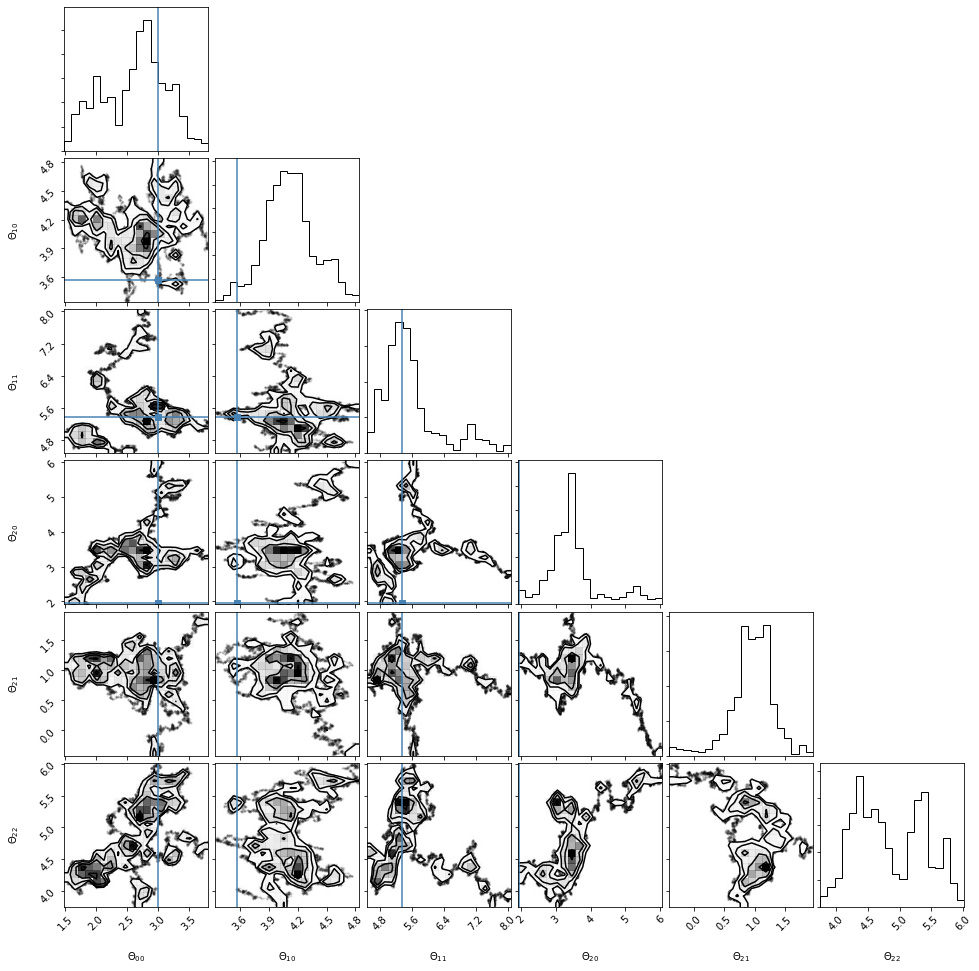

In [27]:
# Corner plot
labels = np.array([[f'$\Theta_{{{i}{j}}}$' for j in range(ndims)] for i in range(ndims)])
labels = np.tril(labels).flatten()
labels = labels[labels!='']
f = corner.corner(xs.reshape(-1,n_args), truths=mat_to_LT(Th_tru), 
                  labels=labels)

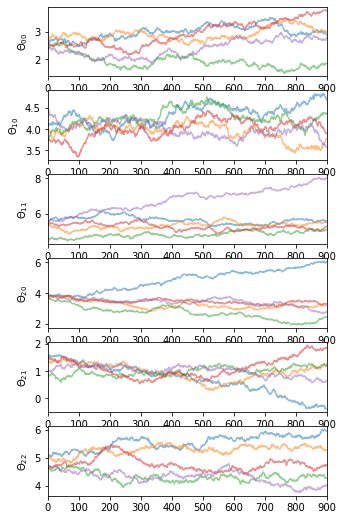

In [28]:
# Trace
r = 10

f, axs = plt.subplots(n_args,1, figsize=(5, 1.5*n_args))

for j in range(n_args):
    for i in range(N_chains):
        axs[j].plot(xs[i,::r,j], alpha=0.5)
    axs[j].set_ylabel(labels[j])
    axs[j].set_xlim(0,xs.shape[1]/r)


# Evaluation

In [1]:
import time
import matplotlib.pyplot as plt

In [19]:
"""
Setup an experiment for one time. 
"""
def time_acc_per_experiment(steps, sampler, data, init_x):
    time0 = time.time()
    xs, acc = sampler.sample_with_acc(steps, data, init_x)
    time_cost = time.time() - time0
    return xs, time_cost, acc

"""
Setup experiments with different steps. 
"""
def time_acc_experiments(step_range, sampler, data, init_x):
    times = []
    accs = []
    xss = []
    for step in step_range:
        xs, time_cost, acc = time_acc_per_experiment(step, sampler, data, init_x)
        times.append(time_cost)
        accs.append(acc)
        xss.append(xs)
    return xss, times, accs


"""
Setup experiments with different steps for different samplers.
"""
def time_acc_with_different_samplers(step_range, sampler_dict, data, init_x):
    results = {}
    for k, sampler in sampler_dict.items():
        results[k] = {}
        xss, times, accs = time_acc_experiments(step_range, sampler, data, init_x)
        results[k]['xs'] = xss
        results[k]['time'] = times
        results[k]['acc'] = accs
    return results

# scripts for plotting computational cost vs.  acceptance ratio trade-offs
def plot_trade_offs(results, step_range):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title('Time vs. Steps on Different Samplers')
    ax1.set_xlabel('Sample steps')
    ax1.set_ylabel('Compute time(s)')
    for k, r in results.items():
        ax1.plot(step_range, r['time'], '-*', label=k)
    ax1.legend()
    ax1.set_xticks(step_range)

    ax2.set_title('Acceptance Rate vs. Steps on Different Samplers')
    ax2.set_xlabel('Sample steps')
    ax2.set_ylabel('Acceptance rate')
    for k, r in results.items():
        ax2.plot(step_range, r['acc'], '-*', label=k, )
    ax2.legend()
    ax2.set_xticks(step_range)

In [20]:
step_range = range(1000, 2001, 500)
samplers = {
    'leap_frog': HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2),
    'dummy': HMC(logp, dlogp, dt=1e-4, L=10, M=0.1*np.identity(2), n_args=2)
    }
results = time_acc_with_different_samplers(step_range, samplers, data, [0.1,0.5])

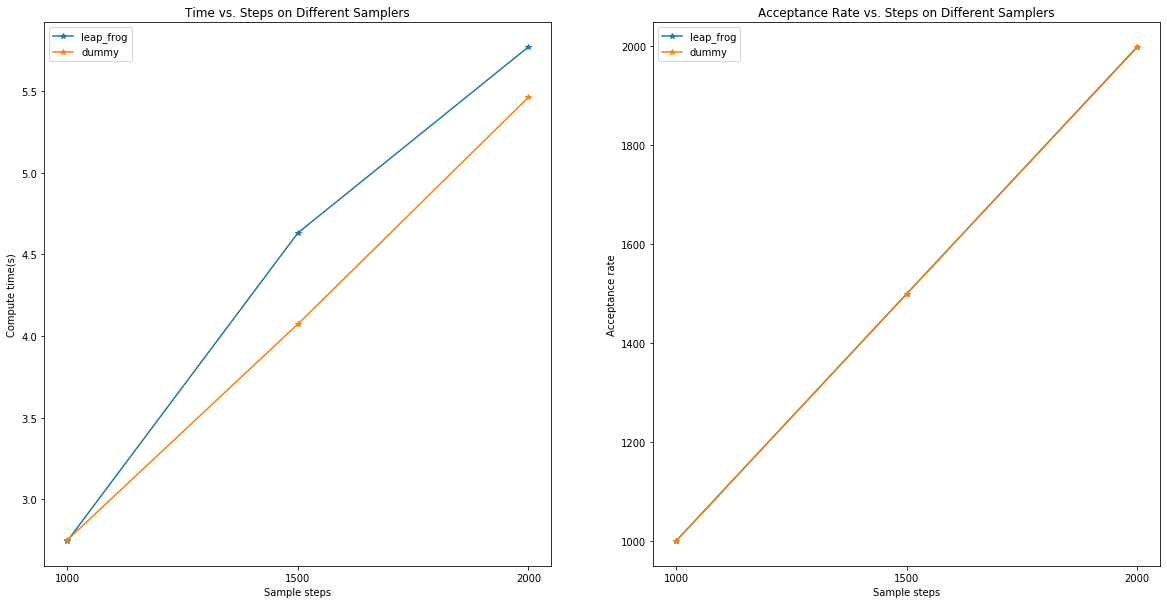

In [21]:
plot_trade_offs(results, step_range)

In [28]:
# Get samples with step 2000
samples = np.array([r['xs'][-1] for _, r in results.items()])

In [62]:
# Get sequence with "leapforg" sampler
x = samples[0]

In [66]:
def effective_sample_size(x, functruncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=-1)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess

"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)

In [65]:
leap_frog_ess = effective_sample_size(x)
print(leap_frog_ess)

115.46017290998668
